# Fraud Rules - CNN+AdaBoost model

In [1]:
'''
Import Libraries
'''

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer

from lime import lime_tabular

from sklearn import metrics
import matplotlib.cm as cm
from scipy import stats


import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
ada_df = pd.read_csv('results/cnn_ab_df.csv')

In [3]:
ada_df

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum,predicted_label
0,ebc46ba67c67daa,65,49.23,13.85,36.92,3.08,1.54,1.54,89.23,4.62,...,0.292308,2.246154,30.061538,12,5.42,0,0.666638,0,0.0000,1
1,4e56e6ef8c89668,13,69.23,23.08,7.69,0.00,15.38,0.00,84.62,0.00,...,0.000000,1.000000,21.846154,5,2.60,1,0.666638,1,0.5000,1
2,81339ae7bb3dca4,31,87.10,6.45,6.45,32.26,3.23,3.23,58.06,3.23,...,0.000000,1.193548,30.967742,5,6.20,0,0.666638,1,0.3333,1
3,42b876d90ae840a,52,90.38,9.62,0.00,5.77,5.77,1.92,86.54,0.00,...,0.269231,2.307692,28.576923,5,10.40,1,0.666638,2,0.5000,1
4,19895d29d20183d,219,34.70,64.38,0.91,0.00,5.48,9.59,78.08,6.85,...,0.063927,0.785388,31.242009,56,3.91,1,0.666638,3,0.6000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12611,a9b4fd3bce0b77e,82,89.02,9.76,1.22,13.41,1.22,4.88,35.37,45.12,...,0.048780,2.841463,61.341463,15,5.47,0,0.180273,185,0.0147,0
12612,06e4101c7c5b27a,95,100.00,0.00,0.00,23.16,10.53,3.16,54.74,8.42,...,0.389474,2.315789,61.315789,15,6.33,0,0.180273,185,0.0147,0
12613,3e8ff81de4ef8a1,59,86.44,13.56,0.00,3.39,3.39,6.78,37.29,49.15,...,0.745763,3.169492,46.779661,14,4.21,0,0.180273,185,0.0147,0
12614,e2d56156ad55d33,15,100.00,0.00,0.00,13.33,13.33,6.67,66.67,0.00,...,0.000000,0.000000,55.533333,6,2.50,0,0.180273,185,0.0147,0


In [4]:
#### Ada

In [5]:
# Both classes
ada_df[['Prix_monture', 'age_moyen', 'Pourcent_remise_monture', 'nb_lignes_PEC', 'PEC_REF']].describe().T


,count,mean,std,min,25%,50%,75%,max
Prix_monture,12616.0,143.675605,41.954150,0.0,117.435268,137.433608,161.800431,450.000000
age_moyen,12616.0,45.906099,8.905166,3.0,40.355779,45.516862,51.250000,94.000000
Pourcent_remise_monture,12616.0,5.853695,10.360460,0.0,0.026230,2.461027,6.768466,99.695431
nb_lignes_PEC,12616.0,65.329581,88.617081,1.0,16.000000,39.000000,82.000000,3385.000000
PEC_REF,12616.0,10.973660,13.621664,0.0,0.000000,6.250000,16.540000,100.000000


In [6]:
# 'fraud' class only
ada_df_1 = ada_df[ada_df['predicted_label'] == 1]
ada_df_1

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum,predicted_label
0,ebc46ba67c67daa,65,49.23,13.85,36.92,3.08,1.54,1.54,89.23,4.62,...,0.292308,2.246154,30.061538,12,5.42,0,0.666638,0,0.0000,1
1,4e56e6ef8c89668,13,69.23,23.08,7.69,0.00,15.38,0.00,84.62,0.00,...,0.000000,1.000000,21.846154,5,2.60,1,0.666638,1,0.5000,1
2,81339ae7bb3dca4,31,87.10,6.45,6.45,32.26,3.23,3.23,58.06,3.23,...,0.000000,1.193548,30.967742,5,6.20,0,0.666638,1,0.3333,1
3,42b876d90ae840a,52,90.38,9.62,0.00,5.77,5.77,1.92,86.54,0.00,...,0.269231,2.307692,28.576923,5,10.40,1,0.666638,2,0.5000,1
4,19895d29d20183d,219,34.70,64.38,0.91,0.00,5.48,9.59,78.08,6.85,...,0.063927,0.785388,31.242009,56,3.91,1,0.666638,3,0.6000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,824b0728d897bd6,24,54.17,45.83,0.00,0.00,0.00,4.17,79.17,16.67,...,0.125000,1.791667,39.875000,16,1.50,0,0.437655,167,0.1453,1
1149,e0e93fdbbdfbdf0,85,95.29,0.00,4.71,11.76,7.06,5.88,72.94,2.35,...,0.141176,0.976471,44.564706,35,2.43,0,0.437655,167,0.1452,1
1150,51f5ed5e849cce1,197,98.98,0.00,1.02,16.24,6.09,1.52,74.11,2.03,...,0.451777,1.817259,42.329949,62,3.18,0,0.437655,167,0.1451,1
1151,1ec874259acf2a8,2,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,...,0.000000,0.000000,30.500000,1,2.00,0,0.437655,167,0.1450,1


In [7]:
ada_df_1[['Prix_monture', 'nb_lignes_PEC', 'PEC_REF', 'age_moyen']].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Prix_monture,1153.0,194.34,43.84,52.11,161.86,189.88,222.49,418.64
nb_lignes_PEC,1153.0,61.91,48.84,1.00,31.00,50.00,80.00,544.00
PEC_REF,1153.0,5.80,5.85,0.00,1.75,4.55,8.47,67.44
age_moyen,1153.0,37.52,5.78,6.77,34.27,37.76,41.34,61.00


### Rule 1

In [8]:
rule1 = ada_df_1[(ada_df_1['Prix_monture'] >= 100) & (ada_df_1['Prix_monture'] <= 300)]

rule1

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum,predicted_label
0,ebc46ba67c67daa,65,49.23,13.85,36.92,3.08,1.54,1.54,89.23,4.62,...,0.292308,2.246154,30.061538,12,5.42,0,0.666638,0,0.0000,1
1,4e56e6ef8c89668,13,69.23,23.08,7.69,0.00,15.38,0.00,84.62,0.00,...,0.000000,1.000000,21.846154,5,2.60,1,0.666638,1,0.5000,1
2,81339ae7bb3dca4,31,87.10,6.45,6.45,32.26,3.23,3.23,58.06,3.23,...,0.000000,1.193548,30.967742,5,6.20,0,0.666638,1,0.3333,1
3,42b876d90ae840a,52,90.38,9.62,0.00,5.77,5.77,1.92,86.54,0.00,...,0.269231,2.307692,28.576923,5,10.40,1,0.666638,2,0.5000,1
4,19895d29d20183d,219,34.70,64.38,0.91,0.00,5.48,9.59,78.08,6.85,...,0.063927,0.785388,31.242009,56,3.91,1,0.666638,3,0.6000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,824b0728d897bd6,24,54.17,45.83,0.00,0.00,0.00,4.17,79.17,16.67,...,0.125000,1.791667,39.875000,16,1.50,0,0.437655,167,0.1453,1
1149,e0e93fdbbdfbdf0,85,95.29,0.00,4.71,11.76,7.06,5.88,72.94,2.35,...,0.141176,0.976471,44.564706,35,2.43,0,0.437655,167,0.1452,1
1150,51f5ed5e849cce1,197,98.98,0.00,1.02,16.24,6.09,1.52,74.11,2.03,...,0.451777,1.817259,42.329949,62,3.18,0,0.437655,167,0.1451,1
1151,1ec874259acf2a8,2,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,...,0.000000,0.000000,30.500000,1,2.00,0,0.437655,167,0.1450,1


### Rule 2

In [9]:
rule2 = ada_df_1[(ada_df_1['nb_lignes_PEC'] >= 1) & (ada_df_1['nb_lignes_PEC'] <= 80)]

rule2

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum,predicted_label
0,ebc46ba67c67daa,65,49.23,13.85,36.92,3.08,1.54,1.54,89.23,4.62,...,0.292308,2.246154,30.061538,12,5.42,0,0.666638,0,0.0000,1
1,4e56e6ef8c89668,13,69.23,23.08,7.69,0.00,15.38,0.00,84.62,0.00,...,0.000000,1.000000,21.846154,5,2.60,1,0.666638,1,0.5000,1
2,81339ae7bb3dca4,31,87.10,6.45,6.45,32.26,3.23,3.23,58.06,3.23,...,0.000000,1.193548,30.967742,5,6.20,0,0.666638,1,0.3333,1
3,42b876d90ae840a,52,90.38,9.62,0.00,5.77,5.77,1.92,86.54,0.00,...,0.269231,2.307692,28.576923,5,10.40,1,0.666638,2,0.5000,1
5,e6a9fcfb2065287,4,75.00,25.00,0.00,0.00,50.00,50.00,0.00,0.00,...,0.750000,2.500000,38.500000,3,1.33,1,0.666638,4,0.6667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,ca5579a7b63a8e9,28,100.00,0.00,0.00,10.71,17.86,0.00,57.14,14.29,...,0.321429,1.714286,40.464286,7,4.00,0,0.437655,167,0.1456,1
1147,bf8137a568ce5ce,10,80.00,10.00,10.00,0.00,0.00,10.00,90.00,0.00,...,0.000000,2.200000,33.000000,9,1.11,0,0.437655,167,0.1455,1
1148,824b0728d897bd6,24,54.17,45.83,0.00,0.00,0.00,4.17,79.17,16.67,...,0.125000,1.791667,39.875000,16,1.50,0,0.437655,167,0.1453,1
1151,1ec874259acf2a8,2,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,...,0.000000,0.000000,30.500000,1,2.00,0,0.437655,167,0.1450,1


### Rule 3

In [10]:
rule3 = ada_df_1[(ada_df_1['age_moyen'] >= 34) & (ada_df_1['age_moyen'] <= 45)]
rule3

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum,predicted_label
5,e6a9fcfb2065287,4,75.00,25.00,0.00,0.00,50.00,50.00,0.00,0.00,...,0.750000,2.500000,38.500000,3,1.33,1,0.666638,4,0.6667,1
9,fffeb461a536fd1,77,98.70,0.00,1.30,12.99,7.79,6.49,68.83,3.90,...,0.181818,1.389610,37.337662,5,15.40,1,0.666638,8,0.8000,1
14,d57fcfc0cd35aab,32,100.00,0.00,0.00,0.00,9.38,0.00,84.38,6.25,...,0.218750,3.500000,34.500000,4,8.00,1,0.666638,13,0.8667,1
37,9885a939124faec,43,88.37,9.30,2.33,0.00,4.65,2.33,79.07,13.95,...,0.255814,1.976744,35.674419,10,4.30,1,0.491647,33,0.8684,1
39,5526a73da043943,235,70.64,17.02,12.34,2.55,8.51,4.68,74.04,10.21,...,0.153191,1.795745,34.425532,87,2.70,1,0.491647,35,0.8750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,6d9278b54c51734,17,52.94,47.06,0.00,17.65,35.29,0.00,35.29,11.76,...,0.117647,0.941176,44.941176,10,1.70,0,0.437655,167,0.1457,1
1146,ca5579a7b63a8e9,28,100.00,0.00,0.00,10.71,17.86,0.00,57.14,14.29,...,0.321429,1.714286,40.464286,7,4.00,0,0.437655,167,0.1456,1
1148,824b0728d897bd6,24,54.17,45.83,0.00,0.00,0.00,4.17,79.17,16.67,...,0.125000,1.791667,39.875000,16,1.50,0,0.437655,167,0.1453,1
1149,e0e93fdbbdfbdf0,85,95.29,0.00,4.71,11.76,7.06,5.88,72.94,2.35,...,0.141176,0.976471,44.564706,35,2.43,0,0.437655,167,0.1452,1


### Rule 4

In [11]:
rule4 = ada_df_1[ada_df['PEC_REF'] <= 10]
rule4

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,class,decision_scores,cum_sum,cum,predicted_label
0,ebc46ba67c67daa,65,49.23,13.85,36.92,3.08,1.54,1.54,89.23,4.62,...,0.292308,2.246154,30.061538,12,5.42,0,0.666638,0,0.0000,1
1,4e56e6ef8c89668,13,69.23,23.08,7.69,0.00,15.38,0.00,84.62,0.00,...,0.000000,1.000000,21.846154,5,2.60,1,0.666638,1,0.5000,1
2,81339ae7bb3dca4,31,87.10,6.45,6.45,32.26,3.23,3.23,58.06,3.23,...,0.000000,1.193548,30.967742,5,6.20,0,0.666638,1,0.3333,1
3,42b876d90ae840a,52,90.38,9.62,0.00,5.77,5.77,1.92,86.54,0.00,...,0.269231,2.307692,28.576923,5,10.40,1,0.666638,2,0.5000,1
4,19895d29d20183d,219,34.70,64.38,0.91,0.00,5.48,9.59,78.08,6.85,...,0.063927,0.785388,31.242009,56,3.91,1,0.666638,3,0.6000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,bf8137a568ce5ce,10,80.00,10.00,10.00,0.00,0.00,10.00,90.00,0.00,...,0.000000,2.200000,33.000000,9,1.11,0,0.437655,167,0.1455,1
1149,e0e93fdbbdfbdf0,85,95.29,0.00,4.71,11.76,7.06,5.88,72.94,2.35,...,0.141176,0.976471,44.564706,35,2.43,0,0.437655,167,0.1452,1
1150,51f5ed5e849cce1,197,98.98,0.00,1.02,16.24,6.09,1.52,74.11,2.03,...,0.451777,1.817259,42.329949,62,3.18,0,0.437655,167,0.1451,1
1151,1ec874259acf2a8,2,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,...,0.000000,0.000000,30.500000,1,2.00,0,0.437655,167,0.1450,1


In [12]:
combined = pd.merge(rule4, rule3, on='ref_PS', how='inner')
combined = pd.merge(combined, rule2, on='ref_PS', how='inner')
combined = pd.merge(combined, rule1, on='ref_PS', how='inner')

combined

,ref_PS,nb_lignes_PEC_x,dep_identique_x,dep_limit_x,dep_non_limit_x,PEC_CRE_x,PEC_ANN_x,PEC_ACC_x,PEC_FAC_x,PEC_REF_x,...,cor_addition_VG_y,facteur_correction_y,age_moyen_y,nb_prescripteurs_y,nb_PEC_par_prescripteurs_y,class_y,decision_scores_y,cum_sum_y,cum_y,predicted_label_y
0,fffeb461a536fd1,77,98.70,0.00,1.30,12.99,7.79,6.49,68.83,3.90,...,0.181818,1.389610,37.337662,5,15.40,1,0.666638,8,0.8000,1
1,d57fcfc0cd35aab,32,100.00,0.00,0.00,0.00,9.38,0.00,84.38,6.25,...,0.218750,3.500000,34.500000,4,8.00,1,0.666638,13,0.8667,1
2,48d66f3d0731dbf,54,87.04,7.41,5.56,7.41,7.41,0.00,75.93,9.26,...,0.055556,1.018519,34.074074,27,2.00,1,0.491647,53,0.5638,1
3,377ecc8ba8684f7,18,33.33,0.00,66.67,0.00,5.56,0.00,88.89,5.56,...,0.388889,3.000000,37.833333,5,3.60,1,0.491647,54,0.5625,1
4,3b9f26321e61dc9,7,14.29,14.29,71.43,0.00,14.29,0.00,85.71,0.00,...,0.000000,3.857143,37.285714,7,1.00,0,0.489453,55,0.5340,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,f3c49f40667bcf8,46,84.78,13.04,2.17,8.70,8.70,2.17,80.43,0.00,...,0.478261,3.956522,34.000000,20,2.30,0,0.437655,167,0.1475,1
484,d6621e666ea61a3,43,90.70,0.00,9.30,9.30,0.00,13.95,74.42,2.33,...,0.000000,0.000000,42.674419,14,3.07,0,0.437655,167,0.1473,1
485,1c0b20a7cbe9e38,55,61.82,38.18,0.00,14.55,7.27,0.00,72.73,5.45,...,0.181818,1.781818,35.418182,16,3.44,0,0.437655,167,0.1464,1
486,c7b821d62a0a230,27,77.78,22.22,0.00,18.52,0.00,0.00,81.48,0.00,...,0.074074,0.925926,34.703704,10,2.70,0,0.437655,167,0.1462,1


<Figure size 504x360 with 0 Axes>

<AxesSubplot:xlabel='Prix_monture', ylabel='predicted_label'>

Text(0.5, 1.0, 'Feature:Prix_monture - distribution with class')

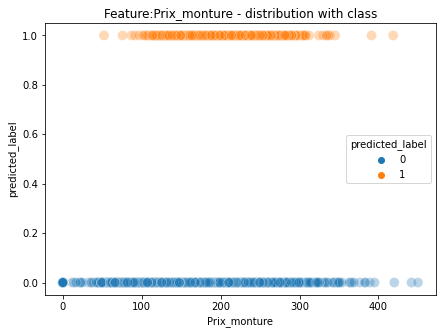

<Figure size 504x360 with 0 Axes>

<AxesSubplot:xlabel='age_moyen', ylabel='predicted_label'>

Text(0.5, 1.0, 'Feature:age_moyen - distribution with class')

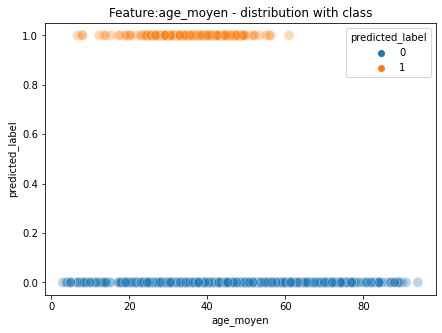

<Figure size 504x360 with 0 Axes>

<AxesSubplot:xlabel='Pourcent_remise_monture', ylabel='predicted_label'>

Text(0.5, 1.0, 'Feature:Pourcent_remise_monture - distribution with class')

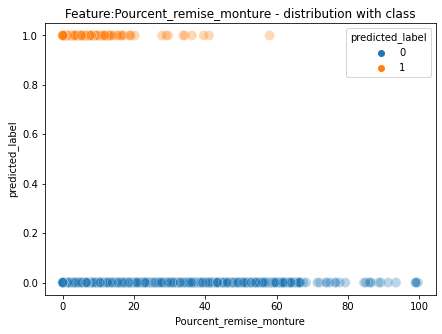

<Figure size 504x360 with 0 Axes>

<AxesSubplot:xlabel='nb_lignes_PEC', ylabel='predicted_label'>

Text(0.5, 1.0, 'Feature:nb_lignes_PEC - distribution with class')

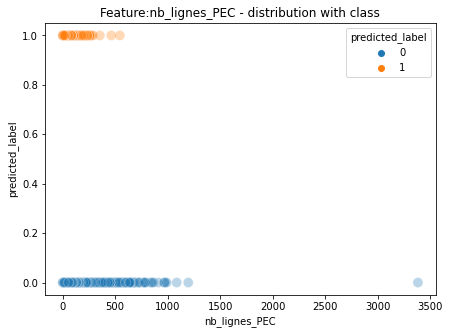

<Figure size 504x360 with 0 Axes>

<AxesSubplot:xlabel='PEC_REF', ylabel='predicted_label'>

Text(0.5, 1.0, 'Feature:PEC_REF - distribution with class')

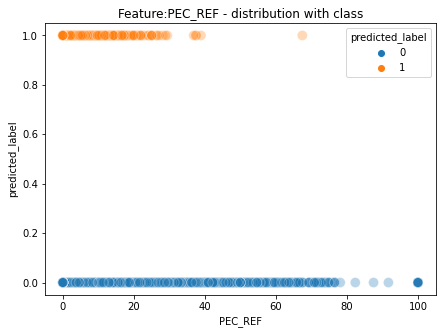

In [13]:
top_features = ['Prix_monture', 'age_moyen', 'Pourcent_remise_monture', 'nb_lignes_PEC', 'PEC_REF']

i=0
for feature in top_features:
    i+=1
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=ada_df, x=feature, y='predicted_label', hue='predicted_label', alpha=0.3, s=100)
    plt.title(f'Feature:{feature} - distribution with class')
    plt.savefig('plots/cnn_rules'+str(i)+'.png', bbox_inches='tight')
    plt.show()